In [1]:
from typing import List, Union

from numpy import sqrt, isinf
import pandas as pd
import xarray as xr
xr.set_options(keep_attrs=True,
               display_expand_data=False)

import plotly.express as px
import plotly.io as pio
# pio.renderers.default='png'

import yfinance as yf

from factor import get_factor_data
from chart import draw_volatility, draw_correlation


In [2]:
halflifes = [21, 63, 126, 252, 512]
data = get_factor_data(halflifes)
factor_master = pd.DataFrame(data['asset'].attrs).T
factor_list = factor_master.index.to_list()

[*********************100%%**********************]  30 of 30 completed


In [3]:
draw_volatility(data.vol, asset='QQQ', vol_type=[21, 63]).show()
draw_correlation(data.corr, asset='QQQ', asset_1='IWM', corr_type=[21, 63]).show()

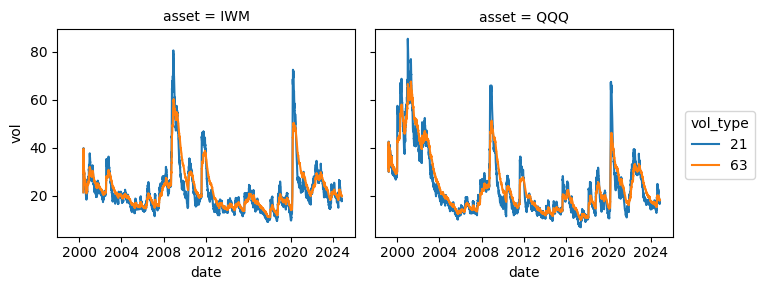

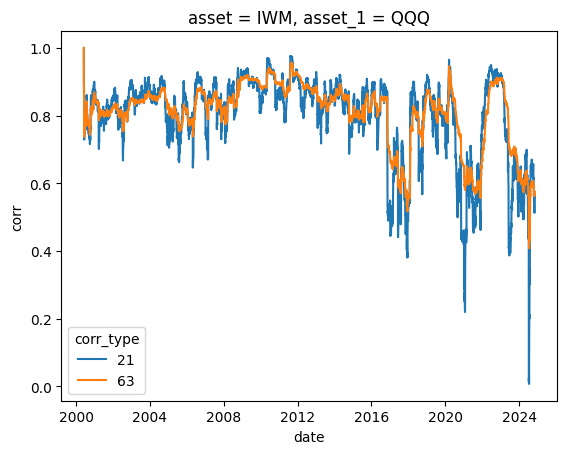

asset_1,SPY,QQQ,IWM
asset,,,
SPY,1.000000,0.945946,0.722749
QQQ,0.945946,1.000000,0.574768
IWM,0.722749,0.574768,1.000000


In [4]:
import matplotlib.pyplot as plt

data.vol.sel(asset=['IWM', 'QQQ'], vol_type=[21, 63]).plot(hue='vol_type', col='asset')
plt.show()

data.corr.sel(asset='IWM', asset_1='QQQ', corr_type=[21, 63]).plot(hue='corr_type')
plt.show()

corr_list = ['SPY', 'QQQ', 'IWM']
data.corr.sel(date=data.date.max(), asset=corr_list, asset_1=corr_list, corr_type=63).to_pandas()

In [5]:
data

<xarray.Dataset> Size: 594MB
Dimensions:     (date: 15174, ohlcv_type: 6, asset: 30, vol_type: 5,
                 asset_1: 30, corr_type: 5)
Coordinates:
  * date        (date) datetime64[ns] 121kB 1965-01-05 1965-01-06 ... 2024-11-05
  * ohlcv_type  (ohlcv_type) object 48B 'adj close' 'close' ... 'open' 'volume'
  * asset       (asset) object 240B 'SPY' 'IWM' 'QQQ' ... 'UUP' 'FXE' 'FXY'
  * vol_type    (vol_type) int64 40B 21 63 126 252 512
  * asset_1     (asset_1) object 240B 'SPY' 'IWM' 'QQQ' ... 'UUP' 'FXE' 'FXY'
  * corr_type   (corr_type) int64 40B 21 63 126 252 512
Data variables:
    ohlcv       (date, ohlcv_type, asset) float64 22MB nan nan nan ... nan nan
    cret        (date, asset) float64 4MB nan nan nan nan ... nan nan nan nan
    ret         (date, asset) float64 4MB nan nan nan nan ... nan nan nan nan
    vol         (vol_type, date, asset) float64 18MB nan nan nan ... 7.359 9.918
    corr        (corr_type, date, asset, asset_1) float64 546MB nan nan ... 1.0

In [6]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Charting scratch

In [ ]:
def format_plotly_title(title: str, subtitles: List[str]) -> dict:
    """
    Format a title and a list of subtitles for a Plotly chart.

    Parameters
    ----------
    title : str
        The main title of the chart.
    subtitles : List[str]
        A list of subtitles for the chart.

    Returns
    -------
    dict
        A dictionary containing the formatted title and subtitles for Plotly.
    """
    # subtitle_text = "<br>".join([f"<sup>{subtitle}</sup>" for subtitle in subtitles])
    subtitle_text = f'<span style="font size: 12px;">{"<br>".join(subtitles)}</span>'
    return {
        'text': f'{title}<br><span style="font size: 12px;">{"<br>".join(subtitles)}</span>',
        # 'x': 0.5,
        # 'xanchor': 'center',
        # 'yanchor': 'top'
    }

# Example usage:
formatted_title = format_plotly_title("Main Title", ["Subtitle 1", "Subtitle 2"])
fig.update_layout(title=formatted_title)
fig.show()
formatted_title

In [ ]:
from typing import Union

def format_plotly_title(title: str, subtitles: Union[str, List[str]]) -> dict:
    """
    Format a title and a list of subtitles for a Plotly chart.

    Parameters
    ----------
    title : str
        The main title of the chart.
    subtitles : Union[str, List[str]]
        A single subtitle or a list of subtitles for the chart.

    Returns
    -------
    dict
        A dictionary containing the formatted title and subtitles for Plotly.
    """
    if isinstance(subtitles, str):
        subtitles = [subtitles]
    subtitle_text = f'<span style="font size: 12px;">{"<br>".join(subtitles)}</span>'
    return {
        'text': f'{title}<br><span style="font size: 12px;">{"<br>".join(subtitles)}</span>',
    }

# Example usage:
formatted_title = format_plotly_title("Main Title", "Single Subtitle")
fig.update_layout(title=formatted_title)
fig.show()
formatted_title


In [ ]:
def plotly_line_chart(da: xr.DataArray, x: str, y: str, color: str = None, title: str = "Line Chart") -> None:
    """
    Produce a Plotly Express line chart given an xarray DataArray.

    Parameters
    ----------
    da : xr.DataArray
        The input xarray DataArray.
    x : str
        The name of the dimension to use for the x-axis.
    y : str
        The name of the dimension to use for the y-axis.
    color : str, optional
        The name of the dimension to use for color grouping, by default None.
    title : str, optional
        The title of the chart, by default "Line Chart".

    Returns
    -------
    None
    """
    df = da.to_series().reset_index()
    fig = px.line(df, x=x, y=y, color=color, title=title, template='plotly_white')
    fig.show()

# Example usage:
# plotly_line_chart(ds.vol, x='date', y='vol', color='vol_type', title='Volatility Over Time')

In [ ]:
da = data.ret.sel(asset='QQQ') / data.ret.sel(asset='IWM')
# data.ret.assign_coordinate()

In [ ]:
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1])).show()

# MDS scratch

In [ ]:
from sklearn.manifold import MDS
from numpy import sqrt

def multi
correlation_matrix = ds.corr.sel(date='2024-10-25', corr_type=63).to_pandas()
dissimilarity_matrix = sqrt(1 - correlation_matrix**2)


mds = MDS(dissimilarity='precomputed', random_state=42)
mds_results = mds.fit_transform(dissimilarity_matrix)
mds_df = pd.DataFrame(mds_results, index=dissimilarity_matrix.index, columns=['dim1', 'dim2'])


print(mds_df)
mds_df.plot.scatter(x='dim1', y='dim2')

px.scatter(mds_df.reset_index(), x='dim1', y='dim2', hover_name='asset')

In [ ]:
from sklearn.manifold import MDS

corr_df = ds.corr.sel(date='2024-10-25', corr_type=63).to_pandas()
mds = MDS(dissimilarity='precomputed', random_state=42)
mds_results = mds.fit_transform(1 - corr_df)
mds_df = pd.DataFrame(mds_results, index=corr_df.index, columns=['MDS1', 'MDS2'])
print(mds_df)
mds_df.plot.scatter(x='MDS1', y='MDS2')

px.scatter(mds_df.reset_index(), x='MDS1', y='MDS2', hover_name='asset')

In [ ]:
mds_results_list = []

for date in ds.date.values:
    corr_df = ds.corr.sel(date=date, corr_type=63).to_pandas()
    imputer = SimpleImputer(strategy='mean')
    corr_df_imputed = imputer.fit_transform(1 - corr_df)
    mds = MDS(dissimilarity='precomputed', random_state=42)
    mds_results = mds.fit_transform(corr_df_imputed)
    mds_results = mds.fit_transform(1 - corr_df)
    mds_results_list.append(mds_results)

mds_results_array = np.stack(mds_results_list)
mds_da = xr.DataArray(mds_results_array, coords=[ds.date, corr_df.index, ['MDS1', 'MDS2']], dims=['date', 'asset', 'mds_dim'])
print(mds_da)
